In [1]:
import os
import logging
import json
import time
import shutil
import joblib
import numpy as np
import mlflow
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import AUC
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Paths (Adjust these based on your local setup)
FINAL_DATA_PATH = r"C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\processed_data\final_data.pkl"  # Adjust path if needed
NEW_DATA_PATH = r"C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\processed_data\processed_data.pkl"
MODEL_DIR = r'C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\models'
BEST_MODEL_PATH = os.path.join(MODEL_DIR, "best_model.keras")
BACKUP_MODEL_PATH = os.path.join(MODEL_DIR, "backup_best_model.keras")
MODEL_METADATA_PATH = os.path.join(MODEL_DIR, "models_metadata.json")

In [3]:
# Logging setup
logging.basicConfig(level=logging.INFO)

In [4]:
# Load Dataset
if not os.path.exists(FINAL_DATA_PATH):
    raise FileNotFoundError("Dataset missing!")

data = joblib.load(FINAL_DATA_PATH)
#logging.info(f"Columns in dataset: {list(data.columns)}")
logging.info(data.head(50))

INFO:root:                             Image_path  Cost_of_vehicle  Min_coverage  \
0   images/train_images/img_4513976.jpg         0.453657      0.453657   
1   images/train_images/img_7764995.jpg         1.485276      1.485276   
2    images/train_images/img_451308.jpg         1.350717      1.350717   
3   images/train_images/img_7768372.jpg        -0.443403     -0.443403   
4   images/train_images/img_7765274.jpg        -1.104984     -1.104984   
5   images/train_images/img_4537770.jpg         1.485276      1.485276   
6   images/train_images/img_7765649.jpg         1.765607      1.765607   
7   images/train_images/img_4518199.jpg        -0.196711     -0.196711   
8   images/train_images/img_4638641.jpg         1.204945      1.204945   
9   images/train_images/img_4516058.jpg        -1.609580     -1.609580   
10  images/train_images/img_4518648.jpg        -0.824653     -0.824653   
11  images/train_images/img_7766913.jpg        -0.420976     -0.420976   
12  images/train_images/img_

In [5]:
# Load Dataset
if not os.path.exists(NEW_DATA_PATH):
    raise FileNotFoundError("Dataset missing!")

data = joblib.load(NEW_DATA_PATH)
#logging.info(f"Columns in dataset: {list(data.columns)}")
logging.info(data.tail(50))

INFO:root:         Image_path  Cost_of_vehicle  Min_coverage  Expiry_date  Max_coverage  \
0     img_46356.jpg         0.740303      0.215039    -2.085579      4.307401   
1    img_453909.jpg        -1.210495      0.570544    -0.370108      5.000374   
2    img_463339.jpg         1.074086     -0.670179     1.183090      0.379668   
3    img_463748.jpg        -1.099782     -2.489013     0.573917      5.265905   
4    img_463980.jpg        -2.196733     -0.872466    -1.682469      2.332247   
5    img_776833.jpg         1.382880      0.630154     1.425213     -0.039037   
6    img_776870.jpg         0.036477     -2.504487     1.140589      4.253282   
7   img_4511084.jpg        -0.719336     -2.633305     0.304748      0.580147   
8   img_4511787.jpg        -0.364276      0.111743    -1.363072      2.189591   
9   img_4512558.jpg        -2.366704     -0.990071     1.186953      0.068096   
10  img_4513036.jpg        -0.909220     -2.067530     0.280278      2.648783   
11  img_4513264.jp

In [6]:
# Preprocess Data
structured_data = data.iloc[:, :18].drop(columns=[data.columns[0], data.columns[5], data.columns[6]]).astype(np.float32).values
image_features = data.iloc[:, 18:].astype(np.float32).values
condition_labels = data['Condition'].astype(np.float32).values  # Binary classification target
amount_labels = data['Amount'].values.reshape(-1, 1)  # Regression target


In [7]:

logging.info(f"Structured Data Shape: {structured_data.shape}")
logging.info(f"Image Features Shape: {image_features.shape}")
logging.info(f"Condition Labels Shape: {condition_labels.shape}")
logging.info(f"Amount Labels Shape: {amount_labels.shape}")

INFO:root:Structured Data Shape: (49, 15)
INFO:root:Image Features Shape: (49, 2048)
INFO:root:Condition Labels Shape: (49,)
INFO:root:Amount Labels Shape: (49, 1)


In [8]:
assert structured_data.shape[0] == image_features.shape[0], "Mismatch in batch size!"

In [9]:
# Load Model
if not os.path.exists(BEST_MODEL_PATH):
    raise FileNotFoundError("Best model missing!")

model = load_model(BEST_MODEL_PATH)
logging.info(f"Model Expected Input Shape: {model.input_shape}")

INFO:root:Model Expected Input Shape: [(None, 2048), (None, 15)]


In [10]:
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dropout):
        print(f"Dropout Rate: {layer.rate}")
    if isinstance(layer, tf.keras.layers.Dense) and layer.kernel_regularizer:
        print(f"L2 Regularization: {layer.kernel_regularizer.l2}")

L2 Regularization: 0.00095
Dropout Rate: 0.2
L2 Regularization: 0.00095
L2 Regularization: 0.00095
Dropout Rate: 0.2
Dropout Rate: 0.2
L2 Regularization: 0.00095
L2 Regularization: 0.00095
Dropout Rate: 0.2
Dropout Rate: 0.2
L2 Regularization: 0.00095
Dropout Rate: 0.2
L2 Regularization: 0.00095
Dropout Rate: 0.2


In [11]:
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dropout):
        layer.training = True  # Should already be active in training mode


In [12]:
for layer in model.layers:
    print(layer.name, layer.trainable)

image_input True
dense True
batch_normalization True
leaky_re_lu True
dropout True
structured_input True
dense_1 True
dense_3 True
batch_normalization_1 True
batch_normalization_3 True
leaky_re_lu_1 True
leaky_re_lu_3 True
dropout_1 True
dropout_3 True
dense_2 True
dense_4 True
batch_normalization_2 True
batch_normalization_4 True
leaky_re_lu_2 True
leaky_re_lu_4 True
dropout_2 True
dropout_4 True
concatenate True
dense_5 True
batch_normalization_5 True
leaky_re_lu_5 True
dropout_5 True
dense_6 True
batch_normalization_6 True
leaky_re_lu_6 True
dropout_6 True
condition_output True
amount_output True


In [13]:
import numpy as np
import collections

# Count occurrences of each class
condition_counts = collections.Counter(condition_labels)
total_samples = len(condition_labels)

# Print class distribution
for label, count in condition_counts.items():
    print(f"Class {label}: {count} samples ({(count/total_samples)*100:.2f}%)")

Class 0.0: 26 samples (53.06%)
Class 1.0: 23 samples (46.94%)


In [14]:
# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss={
        "condition_output": "binary_crossentropy",
        "amount_output": tf.keras.losses.Huber()
    },
    metrics={"condition_output": AUC(), "amount_output": "mae"},
)

In [15]:
# Callbacks
model_version = f"fine_tuned_model_{int(time.time())}.keras"
new_model_path = os.path.join(MODEL_DIR, model_version)
checkpoint = ModelCheckpoint(new_model_path, monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [16]:
# Train Model
history = model.fit(
    [image_features, structured_data],
    {"condition_output": condition_labels, "amount_output": amount_labels},
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - amount_output_loss: 0.7136 - amount_output_mae: 1.1459 - condition_output_auc: 0.4729 - condition_output_loss: 3.4122 - loss: 4.8847 - val_amount_output_loss: 2.1785 - val_amount_output_mae: 2.6747 - val_condition_output_auc: 0.1600 - val_condition_output_loss: 3.7962 - val_loss: 6.7214
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 838ms/step - amount_output_loss: 0.8297 - amount_output_mae: 1.2650 - condition_output_auc: 0.4264 - condition_output_loss: 3.0558 - loss: 4.6295 - val_amount_output_loss: 2.0462 - val_amount_output_mae: 2.5385 - val_condition_output_auc: 0.1800 - val_condition_output_loss: 3.7437 - val_loss: 6.5365
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 805ms/step - amount_output_loss: 0.7696 - amount_output_mae: 1.1819 - condition_output_auc: 0.4452 - condition_output_loss: 2.8875 - loss: 4.2056 - val_amount_output_loss: 1.9278 - val_amount_output_mae: 2.4158 - val_condition_output_auc: 0.1800 - val_condition_output_loss: 3.6773 -

In [17]:
# Get Validation Metrics
val_loss = min(history.history["val_loss"])
condition_auc = max(history.history["val_condition_output_auc"])
amount_mae = min(history.history["val_amount_output_mae"])
logging.info(f"New model validation loss: {val_loss}")
logging.info(f"New model condition accuracy: {condition_auc}")
logging.info(f"New model amount MAE: {amount_mae}")

INFO:root:New model validation loss: 4.979057312011719
INFO:root:New model condition accuracy: 0.4399999976158142
INFO:root:New model amount MAE: 1.3990938663482666


In [18]:
# Extract History
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_auc = history.history["condition_output_auc"]
val_auc = history.history["val_condition_output_auc"]
train_mae = history.history["amount_output_mae"]
val_mae = history.history["val_amount_output_mae"]


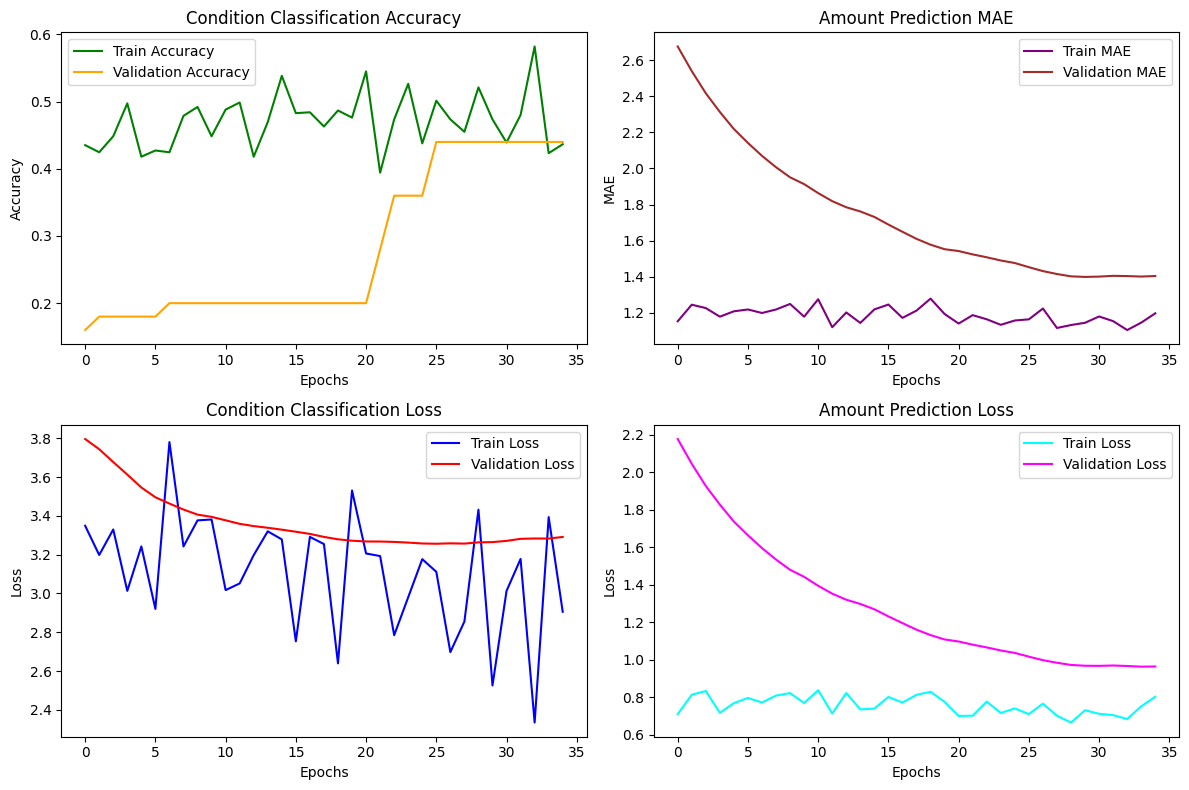

In [19]:
# Plot Accuracy & Loss
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Condition Accuracy
axs[0, 0].plot(history.history['condition_output_auc'], label='Train Accuracy', color='green')
axs[0, 0].plot(history.history['val_condition_output_auc'], label='Validation Accuracy', color='orange')
axs[0, 0].set_title("Condition Classification Accuracy")
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].set_ylabel("Accuracy")
axs[0, 0].legend()

# Amount MAE
axs[0, 1].plot(history.history['amount_output_mae'], label='Train MAE', color='purple')
axs[0, 1].plot(history.history['val_amount_output_mae'], label='Validation MAE', color='brown')
axs[0, 1].set_title("Amount Prediction MAE")
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].set_ylabel("MAE")
axs[0, 1].legend()

# Condition Loss
axs[1, 0].plot(history.history['condition_output_loss'], label='Train Loss', color='blue')
axs[1, 0].plot(history.history['val_condition_output_loss'], label='Validation Loss', color='red')
axs[1, 0].set_title("Condition Classification Loss")
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].legend()

# Amount Loss
axs[1, 1].plot(history.history['amount_output_loss'], label='Train Loss', color='cyan')
axs[1, 1].plot(history.history['val_amount_output_loss'], label='Validation Loss', color='magenta')
axs[1, 1].set_title("Amount Prediction Loss")
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [20]:
# Generate Predictions
preds = model.predict([image_features, structured_data])

# Handle different possible output formats
if isinstance(preds, list):
    if len(preds) == 2:  # Ensure there are two outputs
        condition_preds = np.argmax(preds[0], axis=1)  # First output: classification
        amount_preds = preds[1].flatten()  # Second output: regression
    else:
        raise ValueError("Unexpected number of outputs from the model.")
elif isinstance(preds, dict):
    condition_preds = np.argmax(preds.get("condition_output", []), axis=1)
    amount_preds = preds.get("amount_output", []).flatten()
else:
    raise TypeError("Unexpected prediction output format.")

# Ensure integer type for classification labels
condition_preds = condition_preds.astype(int)

# Print debugging info
print("Condition Predictions Shape:", condition_preds.shape)
print("Amount Predictions Shape:", amount_preds.shape)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
Condition Predictions Shape: (49,)
Amount Predictions Shape: (49,)


In [21]:
# Convert predicted condition output to binary (0 or 1)
condition_preds = (condition_preds.flatten() > 0.5).astype(int)
print("Unique values in condition_labels:", np.unique(condition_preds))

Unique values in condition_labels: [0]


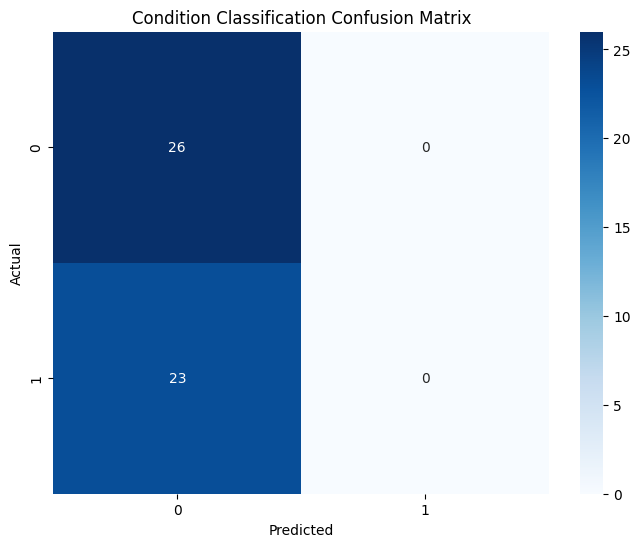

In [22]:
# Confusion Matrix for Condition Classification
cm = confusion_matrix(condition_labels, condition_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Condition Classification Confusion Matrix")
plt.show()